<a href="https://colab.research.google.com/github/ChenHY1217/Projects-In-MLAI/blob/main/ProjectsinMLAIhw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning

## Importing Dataset and Preprocessing

The following bank marketing dataset shows various features regarding individuals and whether they ended up depositing or not.

link to dataset: https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset

### Describe the problem

We are looking at a classification problem where we look at the various recorded features of individuals and predict whether they will deposit for the marketing campaign. This dataset consists of 16 features and over 10,000 data points / rows.

Using Colab cache for faster access to the 'bank-marketing-dataset' dataset.
Original Data Shape: (11162, 17)
   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown

/tmp/ipython-input-4176657613.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_col, data=df, palette='viridis')


<Figure size 1000x600 with 0 Axes>

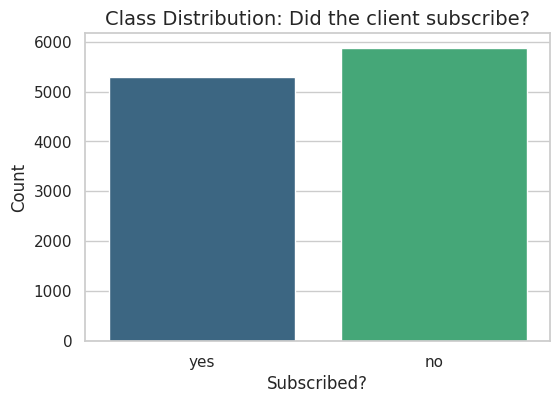

deposit
no     0.52616
yes    0.47384
Name: proportion, dtype: float64


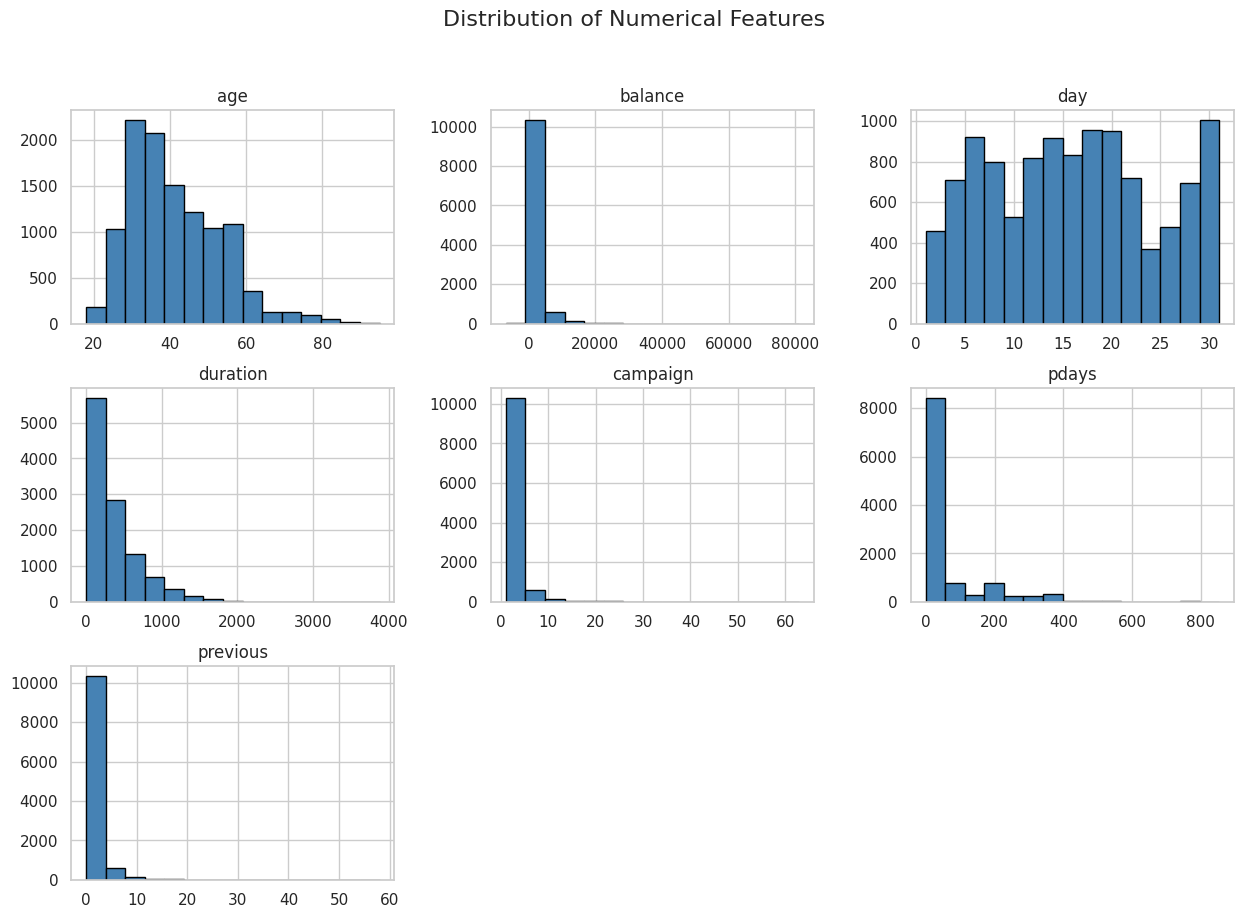

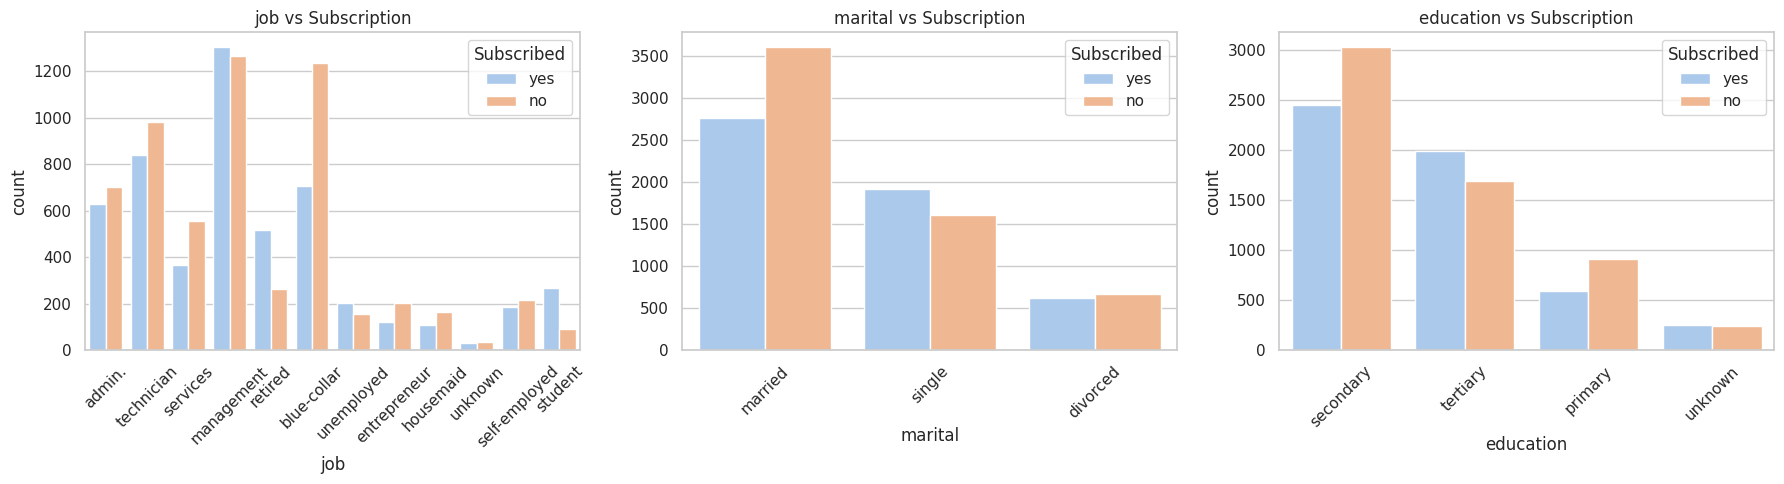

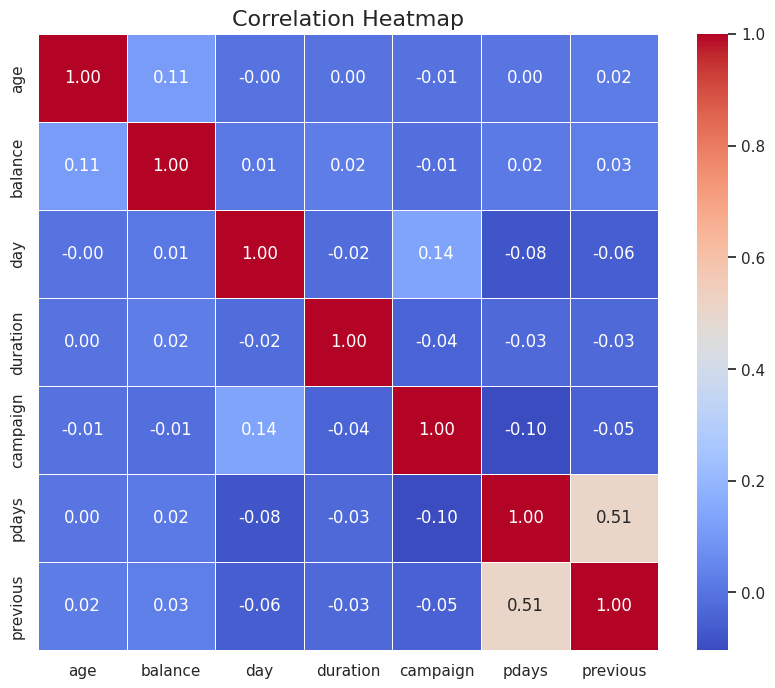

Processed Train Shape: (8929, 42)
Processed Test Shape: (2233, 42)


In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_data(filepath):
    """
    Loads Bank Marketing dataset, performs one-hot encoding,
    binary encoding, splitting, and scaling.
    """
    # load data
    df = pd.read_csv(filepath)

    print(f"Original Data Shape: {df.shape}")

    print(df.head())

    # ------------------ EDA ------------------------
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # check missing values
    print("\nMissing Values per Column:")
    print(df.isnull().sum())

    # check class imbalance
    target_col = 'deposit'

    plt.figure(figsize=(6, 4))
    sns.countplot(x=target_col, data=df, palette='viridis')
    plt.title('Class Distribution: Did the client subscribe?', fontsize=14)
    plt.xlabel('Subscribed?')
    plt.ylabel('Count')
    plt.show()
    print(df[target_col].value_counts(normalize=True))

    # check feature distributions
    num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
    df[num_cols].hist(bins=15, figsize=(15, 10), layout=(3, 3), color='steelblue', edgecolor='black')
    plt.suptitle('Distribution of Numerical Features', fontsize=16)
    plt.show()

    # check correlation between categorical features and target
    # Select interesting categorical columns
    cat_cols = ['job', 'marital', 'education']

    plt.figure(figsize=(18, 5))
    for i, col in enumerate(cat_cols):
        plt.subplot(1, 3, i+1)
        sns.countplot(x=col, hue=target_col, data=df, palette='pastel')
        plt.title(f'{col} vs Subscription')
        plt.xticks(rotation=45)
        plt.legend(title='Subscribed', loc='upper right')

    plt.tight_layout()
    plt.show()

    # check correlation matrix
    corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap', fontsize=16)
    plt.show()
    # --------------------------------------------------

    # encode target variable yes = 1, no = 0
    target_col = 'deposit'
    if target_col in df.columns:
        df[target_col] = df[target_col].map({'yes': 1, 'no': 0})
    else:
        raise ValueError(f"Target column '{target_col}' not found. Check CSV headers.")

    # handle categorical features (One-Hot Encoding)
    df_encoded = pd.get_dummies(df, drop_first=True)

    # Split Features (X) and Target (y)
    X = df_encoded.drop(target_col, axis=1).values
    y = df_encoded[target_col].values.reshape(-1, 1) # Reshape for matrix math (m, 1)

    # Split into Train and Test Sets
    # Using 80% for training, 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # normalize
    scaler = StandardScaler()

    # Fit on training set ONLY to prevent data leakage
    X_train_scaled = scaler.fit_transform(X_train)
    # Apply transform to test set
    X_test_scaled = scaler.transform(X_test)

    print(f"Processed Train Shape: {X_train_scaled.shape}")
    print(f"Processed Test Shape: {X_test_scaled.shape}")

    return X_train_scaled, X_test_scaled, y_train, y_test

path = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")
path = os.path.join(path, "bank.csv")

# load dataset
X_train, X_test, y_train, y_test = load_and_preprocess_data(path)

We performed EDA in the above cell before normalizing and splitting the data.

There is no missing values in any columns. The classes for the target column is rather balanced. If we look at the distribution for the features, we notice that some features are heavily left skewed. This introduces the need for rescaling with standard scaler.

In addition, I've also included correlation matrix and histogram plots of categorical features vs. target for visualization.

## Part 1 - Implementing Neural Network from scratch

In [23]:
import numpy as np
import pandas as pd

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        """
        - input_size: Number of features in the input data
        - hidden_size: Number of neurons in the hidden layer
        - output_size: Number of output neurons (usually 1 for binary classification)
        """
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))

        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

        self.grads = {}
        self.cache = {}

    def sigmoid(self, z):
        """Sigmoid activation function: 1 / (1 + e^-z)"""
        # Clip z to prevent overflow/underflow warnings
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, A):
        """Derivative of the sigmoid function"""
        return A * (1 - A)

    def forward_propagation(self, X):
        """
        Perform forward pass
        X: Input data (m_samples, input_size)
        """

        # layer 1
        z1 = np.dot(X, self.W1) + self.b1
        self.cache['z1'] = z1
        a1 = self.sigmoid(z1)
        self.cache['a1'] = a1

        # layer 2
        z2 = np.dot(a1, self.W2) + self.b2
        self.cache['z2'] = z2
        a2 = self.sigmoid(z2)
        self.cache['a2'] = a2

        return a2

    def cost(self, y_true, y_pred):
        """
        Compute the binary cross-entropy loss
        y_true: True labels (m_samples, 1)
        y_pred: Predicted probabilities (m_samples, 1)
        """
        m = y_true.shape[0]
        cost = (-1 / m) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return np.squeeze(cost)

    def backward_propagation(self, X, y):
        """
        Perform backward pass, compute gradients
        """
        m = X.shape[0]

        a1 = self.cache['a1']
        a2 = self.cache['a2']

        dz2 = a2 - y
        self.grads['dW2'] = np.dot(a1.T, dz2) / m

        self.grads['db2'] = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.W2.T) * self.sigmoid_derivative(a1)

        self.grads['dW1'] = np.dot(X.T, dz1) / m

        self.grads['db1'] = np.sum(dz1, axis=0, keepdims=True) / m

    def train(self, X, y, learning_rate, epochs):
        """
        Train the neural network using GD
        """
        loss_history = []

        for epoch in range(epochs):
            # forward pass
            y_pred = self.forward_propagation(X)
            loss = self.cost(y, y_pred)
            loss_history.append(loss)

            # backward pass
            self.backward_propagation(X, y)

            self.W1 -= learning_rate * self.grads['dW1']
            self.b1 -= learning_rate * self.grads['db1']
            self.W2 -= learning_rate * self.grads['dW2']
            self.b2 -= learning_rate * self.grads["db2"]

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

        return loss_history

    def predict(self, X):
        """
        Predict labels (1 or 0)
        """
        y_pred = self.forward_propagation(X)
        predictions = (y_pred > 0.5)
        return predictions

In [24]:
from sklearn.metrics import accuracy_score, classification_report

# Initialize Model

input_features = X_train.shape[1]
hidden_neurons = 64                # tunable
output_neurons = 1                 # Binary classification
learning_rate = 0.1
epochs = 10000

print(f"Initializing Network: {input_features} inputs -> {hidden_neurons} hidden -> {output_neurons} output")

# Initialize Model
nn = NeuralNetwork(input_features, hidden_neurons, output_neurons)

# Train Model
print("Starting Training...")
history = nn.train(X_train, y_train, learning_rate, epochs)

# Evaluate on Test Set
print("\n--- Evaluation ---")
test_predictions = nn.predict(X_test)

# Calculate Accuracy manually
accuracy = np.mean(test_predictions == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

print(f"Classification Report:")
print(classification_report(y_test, test_predictions))



Initializing Network: 42 inputs -> 64 hidden -> 1 output
Starting Training...
Epoch 0, Loss: 0.6928
Epoch 100, Loss: 0.6890
Epoch 200, Loss: 0.6726
Epoch 300, Loss: 0.6035
Epoch 400, Loss: 0.5096
Epoch 500, Loss: 0.4525
Epoch 600, Loss: 0.4250
Epoch 700, Loss: 0.4132
Epoch 800, Loss: 0.4081
Epoch 900, Loss: 0.4057
Epoch 1000, Loss: 0.4045
Epoch 1100, Loss: 0.4039
Epoch 1200, Loss: 0.4035
Epoch 1300, Loss: 0.4032
Epoch 1400, Loss: 0.4029
Epoch 1500, Loss: 0.4027
Epoch 1600, Loss: 0.4025
Epoch 1700, Loss: 0.4023
Epoch 1800, Loss: 0.4021
Epoch 1900, Loss: 0.4019
Epoch 2000, Loss: 0.4017
Epoch 2100, Loss: 0.4015
Epoch 2200, Loss: 0.4013
Epoch 2300, Loss: 0.4010
Epoch 2400, Loss: 0.4008
Epoch 2500, Loss: 0.4006
Epoch 2600, Loss: 0.4003
Epoch 2700, Loss: 0.4001
Epoch 2800, Loss: 0.3998
Epoch 2900, Loss: 0.3995
Epoch 3000, Loss: 0.3992
Epoch 3100, Loss: 0.3989
Epoch 3200, Loss: 0.3986
Epoch 3300, Loss: 0.3983
Epoch 3400, Loss: 0.3980
Epoch 3500, Loss: 0.3976
Epoch 3600, Loss: 0.3973
Epoch 370

I was able to run this with standard GD because of the vectorized implementation of weight calculations. Thus, I was able to use the whole dataset.

## Part 2 - Neural Network with Deep Learning Framework (Pytorch)

### Research

I decided to utilize Pytorch as the Deep Learning Framework for implementing the 2-layer NN. I looked into the resources listed below to get familiar with the syntax and important class functions. I looked into the official pytorch website to get familiar with the different functions and modules available. Then I looked into geeksforgeeks to see how to actually implement a NN, along with implementing the forward pass, loss function, backward pass, and how to use optimizers.

links:
- https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
- https://www.geeksforgeeks.org/deep-learning/how-to-implement-neural-networks-in-pytorch/

EDA is performed above before scaling and splitting.

In [25]:
import os
import torch
from torch import nn

print(torch.cuda.is_available())
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

True
Using cuda device


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Reload full data
X_train, X_test, y_train, y_test = load_and_preprocess_data(path)

# Create dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)

X_dev_tensor = torch.FloatTensor(X_dev).to(device)
y_dev_tensor = torch.FloatTensor(y_dev).to(device)

X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print(f"Train Shape: {X_train_tensor.shape}")
print(f"Dev Shape:   {X_dev_tensor.shape}")
print(f"Test Shape:  {X_test_tensor.shape}")

Original Data Shape: (11162, 17)
   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  
Processed Train Shape: (8929, 42)
Processed Test Shape: (2233, 42)

### Defining NN

In [27]:
class TwoLayerNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(TwoLayerNN, self).__init__()

    # Layer 1
    self.L1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()

    # Layer 2
    self.L2 = nn.Linear(hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    output = self.L1(x)
    output = self.relu(output)
    output = self.L2(output)
    output = self.sigmoid(output)
    return output

I will be using a ReLU activation function for Layer 1 and a sigmoid function for the output layer. Hidden size is the size (number of neurons) of the hidden layer.

### Training

In [28]:
input_dim = X_train_tensor.shape[1]
hidden_dim = 64  # You can tune this
learning_rate = 0.001
l2_penalty = 0.0001
epochs = 10000

model = TwoLayerNN(input_dim, hidden_dim)
model.to(device) # Move model to the same device as tensors
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_penalty)

train_losses = []
dev_losses = []

print("Starting Training (Pytorch)...")

for epoch in range(epochs):
  model.train()

  # forward pass
  outputs = model(X_train_tensor)
  loss = criterion(outputs, y_train_tensor)

  # backward pass
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  train_losses.append(loss.item())

  # validation
  model.eval()
  with torch.no_grad():
    dev_outputs = model(X_dev_tensor)
    dev_loss = criterion(dev_outputs, y_dev_tensor)

  dev_losses.append(dev_loss.item())

  if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Dev Loss: {dev_loss.item():.4f}')

print("Training complete.")

Starting Training (Pytorch)...
Epoch [100/10000], Train Loss: 0.4532, Dev Loss: 0.4606
Epoch [200/10000], Train Loss: 0.3541, Dev Loss: 0.3825
Epoch [300/10000], Train Loss: 0.3197, Dev Loss: 0.3709
Epoch [400/10000], Train Loss: 0.2951, Dev Loss: 0.3706
Epoch [500/10000], Train Loss: 0.2752, Dev Loss: 0.3747
Epoch [600/10000], Train Loss: 0.2583, Dev Loss: 0.3821
Epoch [700/10000], Train Loss: 0.2430, Dev Loss: 0.3887
Epoch [800/10000], Train Loss: 0.2286, Dev Loss: 0.3973
Epoch [900/10000], Train Loss: 0.2151, Dev Loss: 0.4087
Epoch [1000/10000], Train Loss: 0.2022, Dev Loss: 0.4229
Epoch [1100/10000], Train Loss: 0.1903, Dev Loss: 0.4415
Epoch [1200/10000], Train Loss: 0.1793, Dev Loss: 0.4561
Epoch [1300/10000], Train Loss: 0.1688, Dev Loss: 0.4747
Epoch [1400/10000], Train Loss: 0.1594, Dev Loss: 0.4893
Epoch [1500/10000], Train Loss: 0.1505, Dev Loss: 0.5085
Epoch [1600/10000], Train Loss: 0.1419, Dev Loss: 0.5298
Epoch [1700/10000], Train Loss: 0.1342, Dev Loss: 0.5471
Epoch [18

### Evaluation

In [29]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
    y_pred_cls = (y_pred_probs > 0.5).float() # Threshold at 0.5

    # Calculate Accuracy
    accuracy = (y_pred_cls.eq(y_test_tensor).sum() / float(y_test_tensor.shape[0])).item()

print(f"\nTest Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 79.85%


The training and test datasets are normalized with the sklearn Standard Scaler. The NN was able to fit almost perfectly to the train data, but does not perform too superb on the test data, hinting at overfitting. To fix this, we first conduct hyperparameter tuning with CV and then include regularization.

### K-fold Cross Validation for Hyperparameter Tuning

In [30]:
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
epochs_per_fold = 50

# Define the Grid of Hyperparameters to test
param_grid = {
    'hidden_size': [32, 64, 128],
    'learning_rate': [0.1, 0.01, 0.001, 0.005]
}

best_accuracy = 0.0
best_params = {}

print(f"Starting Grid Search with {n_splits}-Fold CV...")
print("-" * 60)

for hidden_size in param_grid['hidden_size']:
    for lr in param_grid['learning_rate']:

        fold_accuracies = []

        # K-Fold Cross Validation
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):

            # Split data for this fold
            X_fold_train = X_train_tensor[train_idx]
            y_fold_train = y_train_tensor[train_idx]
            X_fold_val = X_train_tensor[val_idx]
            y_fold_val = y_train_tensor[val_idx]

            # Initialize a fresh model for this fold
            model = TwoLayerNN(X_train_tensor.shape[1], hidden_size)
            model.to(device) # Move model to the same device as tensors
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_penalty)
            criterion = nn.BCELoss()

            # Short Training Loop
            for epoch in range(epochs_per_fold):
                model.train()
                optimizer.zero_grad()
                outputs = model(X_fold_train)
                loss = criterion(outputs, y_fold_train)
                loss.backward()
                optimizer.step()

            # Validate
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_fold_val)
                predicted = (val_outputs > 0.5).float()
                acc = (predicted.eq(y_fold_val).sum() / float(y_fold_val.shape[0])).item()
                fold_accuracies.append(acc)

        # Calculate Average Accuracy for this specific combination
        avg_acc = np.mean(fold_accuracies)
        print(f"Params [Hidden: {hidden_size}, LR: {lr}] -> Avg CV Accuracy: {avg_acc*100:.2f}%")

        # Check if this is the best so far
        if avg_acc > best_accuracy:
            best_accuracy = avg_acc
            best_params = {'hidden_size': hidden_size, 'learning_rate': lr}

print("-" * 60)
print(f"BEST PARAMETERS FOUND: {best_params}")
print(f"BEST CV ACCURACY: {best_accuracy*100:.2f}%")

Starting Grid Search with 5-Fold CV...
------------------------------------------------------------
Params [Hidden: 32, LR: 0.1] -> Avg CV Accuracy: 84.36%
Params [Hidden: 32, LR: 0.01] -> Avg CV Accuracy: 84.01%
Params [Hidden: 32, LR: 0.001] -> Avg CV Accuracy: 71.24%
Params [Hidden: 32, LR: 0.005] -> Avg CV Accuracy: 83.00%
Params [Hidden: 64, LR: 0.1] -> Avg CV Accuracy: 84.45%
Params [Hidden: 64, LR: 0.01] -> Avg CV Accuracy: 84.12%
Params [Hidden: 64, LR: 0.001] -> Avg CV Accuracy: 73.92%
Params [Hidden: 64, LR: 0.005] -> Avg CV Accuracy: 83.82%
Params [Hidden: 128, LR: 0.1] -> Avg CV Accuracy: 84.47%
Params [Hidden: 128, LR: 0.01] -> Avg CV Accuracy: 84.18%
Params [Hidden: 128, LR: 0.001] -> Avg CV Accuracy: 76.63%
Params [Hidden: 128, LR: 0.005] -> Avg CV Accuracy: 84.24%
------------------------------------------------------------
BEST PARAMETERS FOUND: {'hidden_size': 128, 'learning_rate': 0.1}
BEST CV ACCURACY: 84.47%


### Train and Test Model with Best Parameters

In [31]:
best_hidden_size = best_params['hidden_size']
best_learning_rate = best_params['learning_rate']

print(f"\nRetraining Final Model with Best Parameters Hidden: {best_hidden_size}, LR: {best_learning_rate}")

final_model = TwoLayerNN(X_train_tensor.shape[1], best_hidden_size)
final_model.to(device)
final_optimizer = optim.Adam(final_model.parameters(), lr=best_learning_rate, weight_decay=l2_penalty)
final_criterion = nn.BCELoss()

final_epochs = 10000

loss_history = []

for epoch in range(final_epochs):
    final_model.train()

    final_optimizer.zero_grad()
    outputs = final_model(X_train_tensor)
    loss = final_criterion(outputs, y_train_tensor)
    loss.backward()
    final_optimizer.step()

    loss_history.append(loss.item())

    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{final_epochs}], Loss: {loss.item():.4f}")

# eval on test set
final_model.eval()
with torch.no_grad():
    test_outputs = final_model(X_test_tensor)
    test_preds = (test_outputs > 0.5).float()

    # Accuracy
    correct = test_preds.eq(y_test_tensor).sum().item()
    total = y_test_tensor.shape[0]
    final_accuracy = correct / total

print("-" * 30)
print(f"Final Test Set Accuracy: {final_accuracy * 100:.2f}%")
print("-" * 30)


Retraining Final Model with Best Parameters Hidden: 128, LR: 0.1
Epoch [100/10000], Loss: 0.2225
Epoch [200/10000], Loss: 0.0853
Epoch [300/10000], Loss: 0.3094
Epoch [400/10000], Loss: 0.3203
Epoch [500/10000], Loss: 0.1047
Epoch [600/10000], Loss: 0.0690
Epoch [700/10000], Loss: 0.0393
Epoch [800/10000], Loss: 0.5269
Epoch [900/10000], Loss: 0.1965
Epoch [1000/10000], Loss: 0.0727
Epoch [1100/10000], Loss: 0.0580
Epoch [1200/10000], Loss: 0.0462
Epoch [1300/10000], Loss: 1.1420
Epoch [1400/10000], Loss: 0.9538
Epoch [1500/10000], Loss: 0.9365
Epoch [1600/10000], Loss: 0.9154
Epoch [1700/10000], Loss: 1.6348
Epoch [1800/10000], Loss: 1.5831
Epoch [1900/10000], Loss: 3.2092
Epoch [2000/10000], Loss: 1.3439
Epoch [2100/10000], Loss: 1.9647
Epoch [2200/10000], Loss: 1.8812
Epoch [2300/10000], Loss: 1.8180
Epoch [2400/10000], Loss: 1.7880
Epoch [2500/10000], Loss: 1.4014
Epoch [2600/10000], Loss: 1.3569
Epoch [2700/10000], Loss: 1.9987
Epoch [2800/10000], Loss: 1.5768
Epoch [2900/10000],

### Discussion

To select hyperparameters, I performed a k=5 fold grid search CV. This gave me the hyperparameters that yielded the best accuracies, which I then used to train the model. I wanted to systematically test different combinations of hyperparameters and their impact on accuracy and CV allowed me to measure that.

I added L2 regularization or weight decay to my optimizer because I noticed that the train error was minimal but the test error / accuracy was not as high as expected. This is clear indication of overfitting, which is typical for Neural Networks.

For the optimization algorithm, I used the Adam optimizer for its faster convergence speed and its resistance to noise.

## Task 4 - Comparison with baseline model

I decided to use the decision tree classifier as my baseline model. This is structurally different from NN and suitable for this task.

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1166
           1       0.75      0.76      0.76      1067

    accuracy                           0.77      2233
   macro avg       0.77      0.77      0.77      2233
weighted avg       0.77      0.77      0.77      2233

Accuracy: 0.767577250335871


<Figure size 600x500 with 0 Axes>

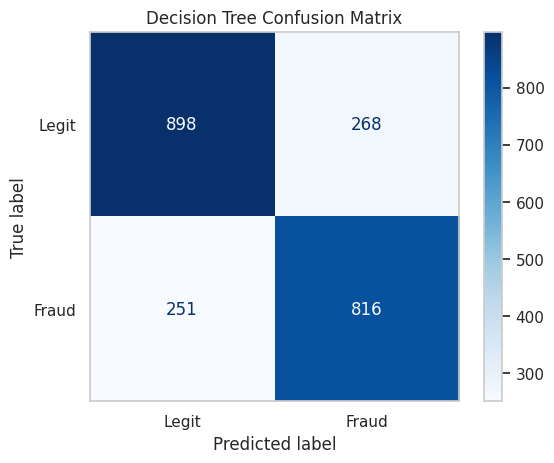

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Create dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train
dt = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
dt.fit(X_train, y_train)

# Evaluate
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Decision Tree Confusion Matrix")
plt.grid(False)
plt.show()



### Comparison

Decision Tree yielded an accuracy of 76.76% while Neural Network yielded an accuracy of 81.86%. However, Neural Network took much longer to train compared to the Decision Tree model. In addition, Neural Network has high complexity with the hidden layer and weights whereas Decision Tree model is easy to interpret.

Neural Network won in accuracy because it was capable of learning the complex interactions between continuous variables which a simple Decision Tree might miss. Also, regularization helped NN generalize more, yielding a better test result.

It appears that the extra complexity of NN along with hyperparameter tuning and regularization helped it perform better than the baseline model. This shows the importance of tuning and regularization.